# Basic Neural Networks 

(to compare pre-transfer learning)

In [1]:
# Standard imports
import os
import datetime
from pathlib import Path
from collections import defaultdict
import scipy
import random
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import joblib
import pickle

# Machine learning libraries
import sklearn            # machine-learning libary with many algorithms implemented
#import xgboost as xgb     # extreme gradient boosting (XGB)
#from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import mean_squared_error

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import *
from tensorflow.keras import Sequential

# Python file with supporting functions
import model_utils

2023-01-08 18:47:51.170539: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
global_model_path = '/home/julias/MLEE-final-project/models/saved_models/global_models'

# Load Split Datasets and Create Versions for Experimentation

## Load Split Datasets

In [3]:
X_df = xr.open_dataset('/home/julias/MLEE-final-project/proc_data/global_split_datasets/X.nc').to_dataframe().dropna()
y_df = xr.open_dataset('/home/julias/MLEE-final-project/proc_data/global_split_datasets/y.nc').to_dataframe().dropna() 
X_train_df = xr.open_dataset('/home/julias/MLEE-final-project/proc_data/global_split_datasets/X_train.nc').to_dataframe().dropna() 
y_train_df = xr.open_dataset('/home/julias/MLEE-final-project/proc_data/global_split_datasets/y_train.nc').to_dataframe().dropna()
X_test_df = xr.open_dataset('/home/julias/MLEE-final-project/proc_data/global_split_datasets/X_test.nc').to_dataframe().dropna() 
y_test_df = xr.open_dataset('/home/julias/MLEE-final-project/proc_data/global_split_datasets/y_test.nc').to_dataframe().dropna() 

### Create Numpy Arrays for Original Data

In [4]:
X_original = X_df.to_numpy()         
y_original = y_df.to_numpy().ravel() 
X_train_original = X_train_df.to_numpy() 
y_train_original = y_train_df.to_numpy().ravel()
X_test_original = X_test_df.to_numpy()  
y_test_original = y_test_df.to_numpy().ravel()

## Create Normalized Dataframes

*Note: Done here, as opposed to in test/train split, so that I can save the original train/test datasets and later determine whether normalization led to improvement. (My group has not historically normalized data before training.)*

In [5]:
X_df_norm = (X_df - X_df.mean())/X_df.std() 
y_df_norm = (y_df - y_df.mean())/y_df.std()
X_train_df_norm = (X_train_df - X_train_df.mean())/X_train_df.std()
y_train_df_norm = (y_train_df - y_train_df.mean())/y_train_df.std()
X_test_df_norm = (X_test_df - X_test_df.mean())/X_test_df.std()
y_test_df_norm = (y_test_df - y_test_df.mean())/y_test_df.std()

### Create Numpy Arrays for Normalized Data

In [6]:
X = X_df_norm.to_numpy()         
y = y_df_norm.to_numpy().ravel() 
X_train = X_train_df_norm.to_numpy()
y_train = y_train_df_norm.to_numpy().ravel()
X_test = X_test_df_norm.to_numpy() 
y_test = y_test_df_norm.to_numpy().ravel()

# Preliminary NN Model 

## Build NN Model

In [ ]:
# NOTE that number of input layer neurons must correspond to number of predictor variables

In [7]:
# set hyperparameters
n_neuron       = 32 #64
activation     = 'LeakyReLU'
num_epochs     = 10 #50
learning_rate  = 0.001
minibatch_size = 64
model_num      = 1

In [8]:
NN_model = Sequential()

NN_model.add(Dense(n_neuron, name='hidden_layer_1', activation=activation,input_shape=(X_train_original.shape[1],))) #  the 1st hidden layer 
NN_model.add(Dense(n_neuron, name='hidden_layer_2', activation=activation)) # the 2nd hidden layer
NN_model.add(Dense(1, name='output_layer', activation='linear')) # the output layer


NN_model.compile(loss='mse',optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate))

2023-01-08 18:49:31.068595: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [9]:
NN_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 hidden_layer_1 (Dense)      (None, 32)                352       
                                                                 
 hidden_layer_2 (Dense)      (None, 32)                1056      
                                                                 
 output_layer (Dense)        (None, 1)                 33        
                                                                 
Total params: 1,441
Trainable params: 1,441
Non-trainable params: 0
_________________________________________________________________


In [10]:
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)


history = NN_model.fit(X_train_df_norm, y_train_df_norm, 
                            batch_size      = minibatch_size,
                            epochs          = num_epochs,
                            validation_split= 0.2, 
                            verbose         = 1,
                            callbacks       = [early_stop])

Epoch 1/10
148320/148320 [==============================] - 175s 1ms/step - loss: 0.1067 - val_loss: 0.3512
Epoch 2/10
148320/148320 [==============================] - 159s 1ms/step - loss: 0.0841 - val_loss: 0.3676
Epoch 3/10
148320/148320 [==============================] - 159s 1ms/step - loss: 0.0794 - val_loss: 0.3585
Epoch 4/10
148320/148320 [==============================] - 161s 1ms/step - loss: 0.0770 - val_loss: 0.3687
Epoch 5/10
148320/148320 [==============================] - 164s 1ms/step - loss: 0.0755 - val_loss: 0.3757
Epoch 6/10
148320/148320 [==============================] - 162s 1ms/step - loss: 0.0743 - val_loss: 0.3363
Epoch 7/10
148320/148320 [==============================] - 162s 1ms/step - loss: 0.0734 - val_loss: 0.3473
Epoch 8/10
148320/148320 [==============================] - 163s 1ms/step - loss: 0.0727 - val_loss: 0.3388
Epoch 9/10
148320/148320 [==============================] - 161s 1ms/step - loss: 0.0720 - val_loss: 0.3334
Epoch 10/10
148320/148320 [=

## Initial Checks

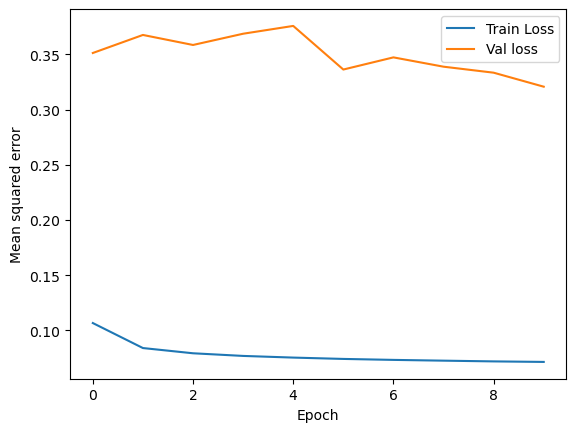

In [12]:
model_utils.plot_history(history)

Validation loss does jump around and is generally higher than the training loss, indicating that the model isn't generalizing well

## Save NN Model

In [13]:
# after training, save:
NN_model.save(os.path.join(global_model_path,'NN_model_prelim_global.h5'))

## Test NN Model

In [14]:
# then reload before start working with test data
NN_prelim_model = load_model(os.path.join(global_model_path,'NN_model_prelim_global.h5'))

In [17]:
y_pred = NN_prelim_model.predict(X_test_df_norm)
mse = mean_squared_error(y_test_df_norm, y_pred)
print("MSE: %.2f" % mse)

92702/92702 [==============================] - 56s 608us/step
MSE: 0.12


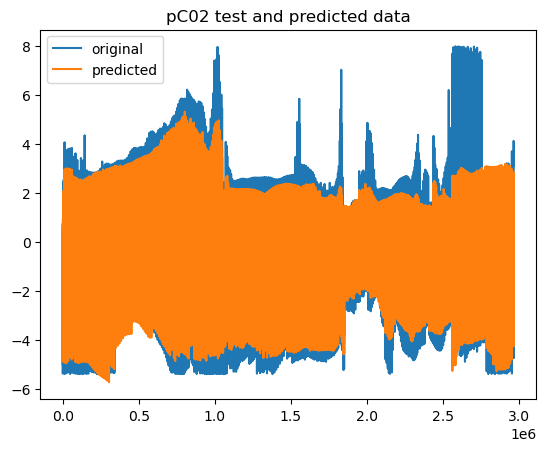

In [18]:
x_ax = range(len(y_test_df_norm))
plt.plot(x_ax, y_test_df_norm, label="original")
plt.plot(x_ax, y_pred, label="predicted")
plt.title("pC02 test and predicted data")
plt.legend()
plt.show()

In [22]:
y_test_df_norm['y_pred']= y_pred
save_prelim_y_pred = y_test_df_norm
save_prelim_y_pred.to_csv('/home/julias/MLEE-final-project/models/saved_models/global_models/save_prelim_y_pred.csv')

# Preliminary NN Model using Normalized Input

## Build NN Model

In [ ]:
# set hyperparameters
n_neuron       = 64
activation     = 'LeakyReLU'
num_epochs     = 50
learning_rate  = 0.001
minibatch_size = 64
model_num      = 1

In [ ]:
NN_model_nprelim = Sequential()

NN_model_nprelim.add(Dense(n_neuron,  activation=activation,input_shape=(X_train.shape[1],))) #  the 1st hidden layer 
NN_model_nprelim.add(Dense(n_neuron,  activation=activation)) # the 2nd hidden layer
NN_model_nprelim.add(Dense(n_neuron,  activation=activation)) # the 3rd hidden layer
NN_model_nprelim.add(Dense(1,  activation='linear')) # the output layer


NN_model_nprelim.compile(loss='mse',optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate))

In [ ]:
NN_model_nprelim.summary()

## Train NN Model

In [ ]:
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)


history_nprelim = NN_model_nprelim.fit(X_train, y_train, 
                            batch_size      = minibatch_size,
                            epochs          = num_epochs,
                            validation_split= 0.2, 
                            verbose         = 1,
                            callbacks       = [early_stop])

## Initial Checks

Can see that validation loss reaches minimums and jumps around, plot to see if trend indicates overfitting

In [ ]:
model_utils.plot_history(history_nprelim)

While the training loss goes down substantially, the validation loss does not show the same trend. Instead, it remains (relatively) high and jumps around.
- Completely fine, just signals that hyperparameter tuning will be needed (as expected)

## Save NN Model

In [ ]:
# after training, save:
NN_model_nprelim.save(os.path.join(global_model_path,'NN_model_nprelim_1.h5'))

## Test NN Model

In [ ]:
NN_model_nprelim = load_model(os.path.join(global_model_path,'NN_model_nprelim_1.h5'))

In [ ]:
y_pred_nprelim = NN_model_nprelim.predict(X_test)
mse = mean_squared_error(y_test, y_pred_nprelim_rerun)
print("MSE: %.2f" % mse)

In [ ]:
x_ax = range(len(y_test))
plt.plot(x_ax, y_test, label="original")
plt.plot(x_ax, y_pred_nprelim, label="predicted")
plt.title("pC02 test and predicted data")
plt.legend()
plt.show()

# Select Approach & Parameters

## Approach

- Based on preliminary experimentation, will train the NN model on normalized data, as is standard machine learning practice
- Comparison completed above for group reference, as data has not historically been normalized prior to training

## Parameters

Experimentation with hyperparameters completed below

### Experiment with NN Model

In [ ]:
# set hyperparameters
n_neuron       = 100
activation     = 'LeakyReLU'
num_epochs     = 100
learning_rate  = 0.002
minibatch_size = 64
model_num      = 1
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)

In [ ]:
NN_model_exp = Sequential()

NN_model_exp.add(Dense(n_neuron,  activation=activation, name='hidden_layer_1', input_shape=(X_train.shape[1],))) #  the 1st hidden layer 
NN_model_exp.add(Dense(n_neuron,  activation=activation, name='hidden_layer_2')) # the 2nd hidden layer
NN_model_exp.add(Dense(n_neuron,  activation=activation, name='hidden_layer_3')) # the 3rd hidden layer
NN_model_exp.add(Dense(1,  activation='linear', name='output_layer')) # the output layer


NN_model_exp.compile(loss='mse',optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate))

In [ ]:
NN_model_exp.summary()

### Train Experimental NN Model

In [ ]:
history_exp = NN_model_exp.fit(X_train, y_train, 
                            batch_size      = minibatch_size,
                            epochs          = num_epochs,
                            validation_split= 0.2, 
                            verbose         = 1,
                            callbacks       = [early_stop])

### Initial Checks on Experimental NN Model

In [ ]:
model_utils.plot_history(history_exp)

In [ ]:
y_pred_exp = NN_model_exp.predict(X_test)
mse = mean_squared_error(y_test, y_pred_exp)
print("MSE: %.2f" % mse)

In [ ]:
x_ax = range(len(y_test))
plt.plot(x_ax, y_test, label="original")
plt.plot(x_ax, y_pred_exp, label="predicted")
plt.title("pC02 test and predicted data")
plt.legend()
plt.show()

### Save Best Experimental NN Model as First of NN Below

In [ ]:
# after training, save:
NN_model_exp.save(os.path.join(global_model_path,'NN_model1.h5'))

# Five Identical NN Models 

## NN Model 1

In [ ]:
NN_model1 = load_model(os.path.join(global_model_path,'NN_model1.h5'))

## NN Model 2

## NN Model 3

## NN Model 4

## NN Model 5